# Applied Data Visualization – Homework 3
*https://www.dataviscourse.net/2024-applied/*


In this homework we will create tabular custom charts in Matplotlib and Seaborn. 



## Your Info and Submission Instructions

* *First name: Logan*
* *Last name: Correa*
* *Email: u1094034@umail.utah.edu* 
* *UID: u1094034*



For your submission, please do the following things: 
* **rename the file to `hw3_lastname.ipynb`**
* **include all files that you need to run the homework, including the data file provided** 
* **don't use absolute paths, but use a relative path to the same directory for referencing data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Useful for this homework
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.style.use('default')
# This next line tells jupyter to render the images inline
%matplotlib inline
import matplotlib_inline
# This renders your figures as vector graphics AND gives you an option to download a PDF too
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

# Part 1: Bubble Grid Chart

For this assignment, we will use a historical data set of medals awarded in Winter Olympics. Recreate the chart below using Matplotlib with the following requirements:

- Each `Discipline` bubble and label should be colored according to the `Sport` variable. You can pick your own colors, as long as they are discernable.
- Each bubble's size should depend on the number of gold medals awarded. (This can be calculated as the number of unique `Event`-`Gender` pairs in the data set.)
- There should be a label noting that 1940 and 1944 Olympic games were not held (due to World War II).

![A bubble grid chart of medals for winter olympics](medals.svg)

Hints you may find useful for this assignment:
- matplotlib's `.patch.Rectangle` and `.add_patch()` for the label box
- matplotlib's `.get_yticklabels()`, `.get_text()`, and `.set_color()` to color the y-axis labels

In [2]:
# Keep this cell
medals_df = pd.read_csv('./winter.csv')
#display(medals_df.head())

# Filter the dataframe for only Gold medals and create a copy
gold_medals_df = medals_df[medals_df['Medal'] == 'Gold'].copy()

# Create a new column for unique gender-event pairs
gold_medals_df['Gender_Event'] = gold_medals_df['Gender'] + '-' + gold_medals_df['Event']

# Count unique gender-event pairs for each sport, discipline, and year
gold_medal_counts = gold_medals_df.groupby(['Year', 'Sport', 'Discipline'])['Gender_Event'].nunique().reset_index()

# Rename columns for clarity
gold_medal_counts.columns = ['Year', 'Sport', 'Discipline', 'Gold Medals']

# Display the first few rows of the new dataframe
display(gold_medal_counts)

,Year,Sport,Discipline,Gold Medals
0,1924,Biathlon,Biathlon,1
1,1924,Bobsleigh,Bobsleigh,1
2,1924,Curling,Curling,1
3,1924,Ice Hockey,Ice Hockey,1
4,1924,Skating,Figure skating,4
...,...,...,...,...
228,2014,Skiing,Cross Country Skiing,12
229,2014,Skiing,Freestyle Skiing,10
230,2014,Skiing,Nordic Combined,3
231,2014,Skiing,Ski Jumping,4


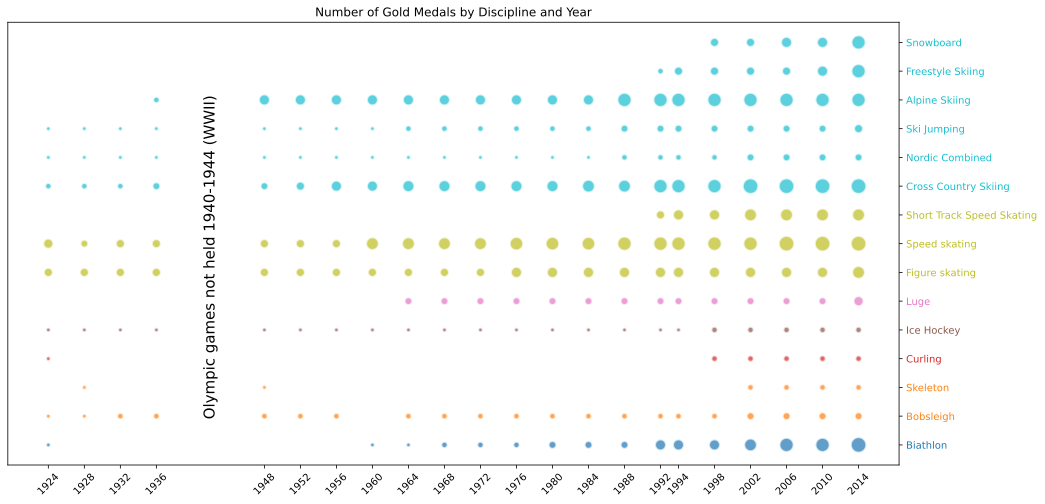

In [10]:

# get unique sports and discipline counts
sport_discipline_counts = gold_medal_counts.groupby('Sport')['Discipline'].nunique()

# Define the base color palette for sports using the updated API
base_colors = plt.colormaps['tab10'].resampled(len(sport_discipline_counts))

# Assign base colors to each sport based on the sorted order
sorted_sport_base_color_map = {sport: base_colors(i) for i, sport in enumerate(sport_discipline_counts.index)}

# Create a new custom order for disciplines based on the sorted sports order
sorted_discipline_order = []
for sport in sport_discipline_counts.index:
    sport_disciplines = gold_medal_counts[gold_medal_counts['Sport'] == sport]['Discipline'].unique()
    sorted_discipline_order.extend(sport_disciplines)

# Reverse the custom order for disciplines
reversed_discipline_order = sorted_discipline_order

# Create a mapping from discipline to its index in the new custom order
reversed_discipline_index_map = {discipline: i for i, discipline in enumerate(reversed_discipline_order)}

# Create a color map for disciplines based on the sorted sport colors
sorted_discipline_colors = {discipline: sorted_sport_base_color_map[gold_medal_counts[gold_medal_counts['Discipline'] == discipline]['Sport'].iloc[0]]
                            for discipline in gold_medal_counts['Discipline'].unique()}

# Plotting the bubble chart with reversed discipline order
plt.figure(figsize=(16, 8))

for discipline in gold_medal_counts['Discipline'].unique():
    discipline_data = gold_medal_counts[gold_medal_counts['Discipline'] == discipline]
    plt.scatter(
        discipline_data['Year'], 
        [reversed_discipline_index_map[discipline]] * len(discipline_data), 
        s=discipline_data['Gold Medals'] * 20,  # Bubble size based on number of gold medals
        color=sorted_discipline_colors[discipline], 
        label=discipline, 
        alpha=0.7, 
        edgecolors='w', 
        linewidth=2
    )

# Adding annotation for missing years (WWII period)
plt.text(1942, 1, 'Olympic games not held 1940-1944 (WWII)', fontsize=15, ha='center', rotation=90)

# Formatting plot
plt.title('Number of Gold Medals by Discipline and Year')
plt.gca().yaxis.tick_right()
plt.yticks(list(range(len(reversed_discipline_order))), reversed_discipline_order)
y_tick_labels = plt.gca().get_yticklabels()
for label in y_tick_labels:
    discipline = label.get_text()
    sport = gold_medal_counts[gold_medal_counts['Discipline'] == discipline]['Sport'].iloc[0]
    label.set_color(sorted_sport_base_color_map[sport])
plt.xticks(gold_medal_counts['Year'].unique(), rotation=45)
plt.show()

# Part 2: Parallel Coordinates

We're back to the familiar Utah Avalanche Center data set for this assignment. Recreate the parallel coordinates chart below using Matplotlib, given the following requirements:

- Subset the data to avalanches caused by skiers in Salt Lake between 2015 and today.
- Highlight (e.g., with another color) avalanches with casualties (i.e. anyone injured, killed, or buried).
- Add a custom legend explaining the highlighting.
- Each axis should range from the minimum to the maximum value of the corresponding variable in the data.

![A parralel coordinates plot of avalance data with fatalities highlighted.](pc.svg)

Hints you may find useful:
- Drop rows that have NaN values in the columns you want to plot.
- Matplotlib's `.twinx()` function is useful to create subfigures that share the same x-axis.
- Note that the ranges of variables are very different. For the lines to fit onto the same chart, all variables should be *normalized* to the range of one variable (for example, if you choose the leftmost variable---year---to be the reference, all other variables should be normalized to range between 2015 and 2023).
- Make sure you first draw the axes, and only then normalize variables to the reference, and then draw.
- You may find it useful to loop over all observations (rows) and `.plot()` each line individually.
- Note that since we are plotting each line individually, matplotlib will not generate a legend. Refer to [the documentation](https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html. ) for guidance on how to create a custom legend.

In [4]:
# Keep this cell

avy_df = pd.read_csv('./avalanches.csv')

# Clean dates and elevation
avy_df['Date'] = pd.to_datetime(avy_df['Date'])
avy_df['Year'] = avy_df['Date'].dt.year.astype('Int64')
avy_df['Month'] = avy_df['Date'].dt.month.astype('Int64')
avy_df['Elevation_Feet'] = pd.to_numeric(avy_df['Elevation'].str.replace('\'', '').str.replace(',', ''))
avy_df['Width_Feet'] = pd.to_numeric(avy_df['Width'].str.replace('\'', '').str.replace(',', ''))
avy_df['Vertical_Feet'] = pd.to_numeric(avy_df['Vertical'].str.replace('\'', '').str.replace(',', ''))

def CleanInchesFeet(x):

    if x!=x: return x

    number = pd.to_numeric(x[:-1].replace(',', ''))
    unit = x[-1]

    if unit == '\"':
        return number
    elif unit == '\'':
        return number*12
    else:
        return float('NaN')
    
avy_df['Depth_Inches'] = avy_df['Depth'].map(lambda x: CleanInchesFeet(x))

# Filter out null dates and incomplete years
avy_df = avy_df[avy_df['Date']==avy_df['Date']]
avy_df = avy_df[avy_df['Year'] > 2015]

In [5]:
# your code here

## Part 3: Scatterplot Matrix

Use seaborn to show a scaterplott matrix of the data you used in Part 2. Make the dots transparent to see which areas are heavily overplotted. 

Hints: 
 * this is one line of code.
 * showing a histogram in the diagonals (instead of a KDE plot) gets around a bug that occurs when using a KDE plot with this dataset

In [6]:
import seaborn as sns

# your code here

## Part 4: Analysis and Comparison

* Analyze the data; under which conditions do casualties occur?
* Compare the scatterplot matrix with the PCP plot. Do you see different patterns in the visualization for this datasets? What are the strengths and weaknesses of each plot? 
  

# Grading Scheme

Part 1: 40%  
Part 2: 40%  
Part 3: 10%  
Part 4: 10%